In [2]:
%load_ext autoreload
%autoreload 2
from EventDriven.backtest import OptionSignalBacktest
import pandas as pd
import numpy as np
from IPython.display import clear_output
from copy import deepcopy


Console Logging & File Logging Can be configured using STREAM_LOG_LEVEL and FILE_LOG_LEVEL in environment variables.
Propagate to root logger can be set using PROPAGATE_TO_ROOT_LOGGER in environment variables.
Example:
STREAM_LOG_LEVEL = 'DEBUG'
FILE_LOG_LEVEL = 'INFO'
PROPAGATE_TO_ROOT_LOGGER = 'False'

2025-03-18 06:47:55 trade.helpers.Logging INFO: Logging Root Directory: /Users/chiemelienwanisobi/cloned_repos/QuantTools/logs
Using Proxy URL: http://18.232.166.224:5500/thetadata


In [3]:
import json
keys = [8, 9, 10, 11, 12 ]
imports_trades = {key: {'trades': pd.read_csv(f'/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/input/profitable_trades_{key}.csv').iloc[:, 1:]} for key in keys}

for key in keys:
    with open(f'/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/input/profitable_weights_{key}.json', 'r') as f:
        weights = json.load(f)
        symbol_list = imports_trades[key]['trades'].Ticker.unique()
        untraded_symbols = [s for s in weights.keys() if s not in imports_trades[key]['trades'].Ticker.unique()]
        for s in untraded_symbols:
            weights.pop(s)
        imports_trades[key]['weights'] = weights

In [4]:
#Backtest class 
## Find a way to not always reinitialize the backtest class, when want to redo
initial_capital = 20_000
capital_tracking = {}
objects = {}
for key in keys:
  print(f"Starting backtest for key: {key}, with initial capital: {initial_capital}")
  ## Set the trades and weights
  trades_ = imports_trades[key]['trades']
  weights = imports_trades[key]['weights']
  objects[key] = {}
  print(weights)
  
  ## Produce max cash map
  max_cash = {}
  cash = 20_000
  for s, w in weights.items():
      if w * cash > 200:
          max_cash[s] = 2
      elif w * cash > 100:
          max_cash[s] = 1
      else:
          max_cash[s] = 0.5
  print(max_cash)

  ## Initialize the backtest class
  evb_backtest = OptionSignalBacktest(trades_, initial_capital=initial_capital)

  ## Set the attributes
  w_map = {x: w  * 0.85 for x, w in weights.items()} ## 85% of the weights for each stock
  evb_backtest.portfolio.weight_map = w_map
  evb_backtest.portfolio.risk_manager.OrderPicker.liquidity_threshold = 50
  evb_backtest.portfolio.risk_manager.OrderPicker.lookback = 10
  evb_backtest.portfolio.risk_manager.OrderPicker.data_availability_threshold = 0.5
  evb_backtest.portfolio.order_settings = {'type': 'naked',
  'specifics': [{'direction': 'long',
    'rel_strike': .850,
    'dte': 365,
    'moneyness_width': 0.35},
    {'direction': 'short',
    'rel_strike': .60,
    'dte': 365,
    'moneyness_width': 0.35}
  ],
  'name': 'vertical_spread'}
  evb_backtest.portfolio.max_contract_price=max_cash
  evb_backtest.executor.commission_rate=0.65/100
  evb_backtest.executor.max_slippage_pct=0.075
  evb_backtest.portfolio.roll_map=30
  evb_backtest.portfolio.dte_reduction_factor=60
 
  custom_attr = {
      'max_cash': max_cash,
      'w_map': w_map,
      'initial_capital': initial_capital,
      'commission_rate': 0.65/100,
      'max_slippage_pct': 0.075,
      'roll_map': 3,
      'dte_reduction_factor': 60,
      'liquidity_threshold': 50,
      'lookback': 10,
      'data_availability_threshold': 0.5
  }
  ## Run the backtest
  evb_backtest.run()

  ## Get the ending capital
  ending_capital = evb_backtest.portfolio._equity['Total'][-1]
  initial_capital = ending_capital
  capital_tracking[key] = ending_capital
  objects[key]['WEIGHTS'] = w_map
  objects[key]['END_CASH'] = ending_capital
  objects[key]['TEST_RESULT'] = {}
  objects[key]['TEST_RESULT']['BACKTESTER'] = evb_backtest.portfolio
  objects[key]['TEST_RESULT']['AGG'] = evb_backtest.portfolio.aggregate()
  objects[key]['CUSTOM_ATTR'] = custom_attr

  clear_output(wait=True)

Starting backtest for key: 12, with initial capital: 82447.47252564327
{'TSLA': 0.13285856444949615, 'META': 0.11763798538677593, 'NFLX': 0.08637009747959587, 'AAPL': 0.0676151517402857, 'COST': 0.0720078264760282, 'AMZN': 0.04879875274933317, 'BA': 0.02991981454758278, 'SBUX': 0.025747839118105225}
{'TSLA': 2, 'META': 2, 'NFLX': 2, 'AAPL': 2, 'COST': 2, 'AMZN': 2, 'BA': 2, 'SBUX': 2}
Processing event: MARKET
Processing event: SIGNAL
Buy Details
Position: {'long': ['TSLA20260116C570'], 'short': ['TSLA20260116C580'], 'trade_id': '&L:TSLA20260116C570&S:TSLA20260116C580', 'close': 1.9250000000000043}, Date: 2025-01-03, Signal: SignalEvent type:LONG, symbol=TSLA, date:2025-01-03 00:00:00, Order Settings=None,Max Contract Price:None , signal_id:TSLA20250103LONG
Max Contract Price: 2, Cash at Hand: 83.79697424318374
Cash at Hand 83.79697424318374 Close 1.9250000000000043
Processing event: SIGNAL
Buy Details
Position: {'long': ['AAPL20260116C320'], 'short': ['AAPL20260116C340'], 'trade_id': '

In [5]:
# objects[11]['TEST_RESULT']['BACKTESTER'].plot_portfolio()
eq = objects[11]['TEST_RESULT']['BACKTESTER']._equity
trades = objects[11]['TEST_RESULT']['BACKTESTER'].trades
transactions = objects[11]['TEST_RESULT']['BACKTESTER'].transactions

(<Axes: xlabel='datetime'>,
 <Axes: xlabel='datetime'>,
 <Axes: xlabel='datetime'>)

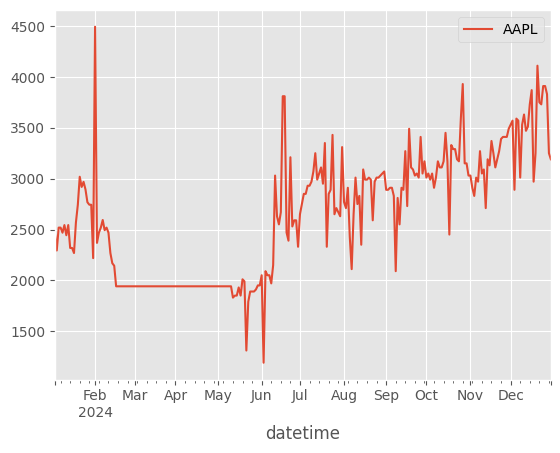

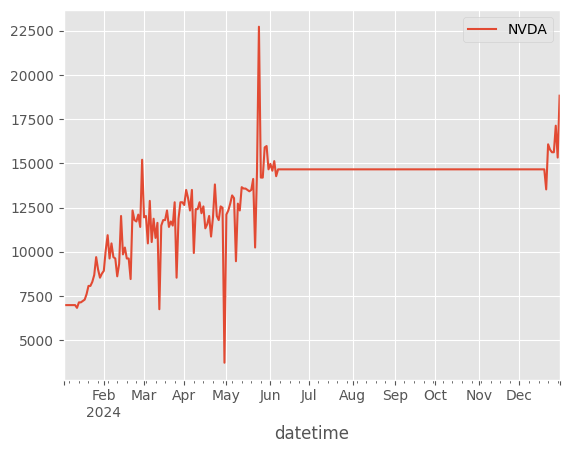

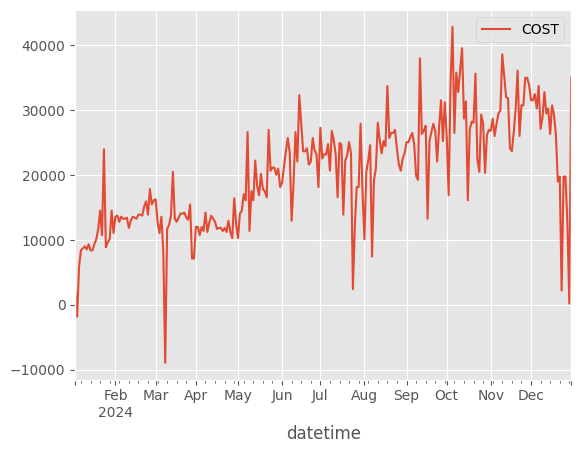

In [6]:
eq.plot(y = 'AAPL'), eq.plot(y = 'NVDA'), eq.plot(y = 'COST')

In [7]:
transactions

,signal_id,datetime,symbol,direction,cash_before,cash_after
0,BA20240103LONG,2024-01-03,BA,BUY,1283.101531,156.917262
1,AAPL20240103LONG,2024-01-03,AAPL,BUY,2620.944737,469.651332
2,AMD20240103LONG,2024-01-03,AMD,BUY,3498.141426,467.513334
3,META20240103LONG,2024-01-03,META,BUY,3367.808418,379.781817
4,COST20240103LONG,2024-01-03,COST,BUY,2286.414213,208.010734
5,NFLX20240103LONG,2024-01-03,NFLX,BUY,1415.955898,199.585073
6,NVDA20240112LONG,2024-01-12,NVDA,BUY,6993.496398,714.868975
7,BA20240103LONG,2024-01-17,BA,SELL,156.917262,443.425270
8,AMZN20240131LONG,2024-01-31,AMZN,BUY,701.270564,98.970056
9,SBUX20240212LONG,2024-02-12,SBUX,BUY,1865.336618,196.036651


In [8]:

trades[trades.Ticker == 'AAPL'][['SignalID', 'Ticker', 'ReturnPct', 'Positions', 'EntryTime', 'ExitTime', 'EntryPrice', 'ExitPrice', 'EntryMarketValue', 'ExitMarketValue', 'Duration']]

,SignalID,Ticker,ReturnPct,Positions,EntryTime,ExitTime,EntryPrice,ExitPrice,EntryMarketValue,ExitMarketValue,Duration
1,AAPL20240103LONG,AAPL,-0.315295,&L:AAPL20250117C220&S:AAPL20241220C225,2024-01-03,2024-02-16,215.129340,147.300220,2138.293405,1486.002203,44
10,AAPL20240513LONG,AAPL,0.729726,&L:AAPL20250620C205&S:AAPL20250620C210,2024-05-13,2024-12-31,213.906915,370.000349,1700.855318,2970.402789,232


<Axes: xlabel='Datetime'>

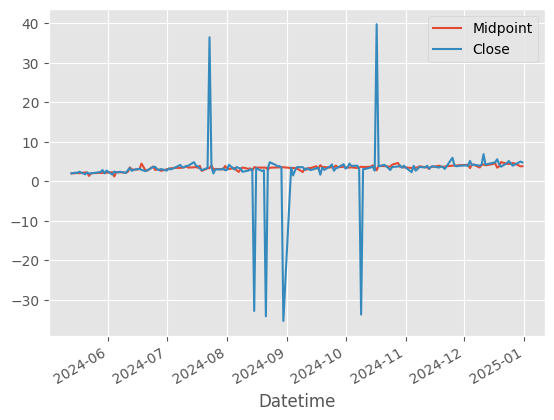

In [9]:
opt_data = objects[11]['TEST_RESULT']['BACKTESTER'].options_data['AAPL20250620C205'] - objects[11]['TEST_RESULT']['BACKTESTER'].options_data['AAPL20250620C210']
opt_data[(opt_data.index >= '2024-05-13') & (opt_data.index <= '2024-12-31')].plot(y = ['Midpoint', 'Close'])

In [10]:
from dbase.DataAPI.ThetaData import retrieve_eod_ohlc,retrieve_quote
retrieve_quote('NVDA', 
                  '2024-12-20',
                  '2025-01-17',
                  'C',
                  '2024-01-12',
                  595.0,
                  print_url=True)

http://127.0.0.1:25510/v2/hist/option/quote?end_date=20241220&root=NVDA&use_csv=true&exp=20250117&ivl=1800000&right=C&start_date=20240112&strike=595000&start_time=34200000&rth=False&end_time=57600000


,Bid_size,Bid_exchange,Bid,Bid_condition,Ask_size,Ask_exchange,Ask,Ask_condition,Date,Midpoint,Weighted_midpoint,time
datetime,,,,,,,,,,,,
2024-01-12 09:30:00,0,1,0.00,50,0,1,0.00,50,20240112,0.000,NaN,09:30:00
2024-01-12 10:00:00,18,73,81.90,50,37,5,82.35,50,20240112,82.125,82.202727,10:00:00
2024-01-12 10:30:00,15,69,81.95,50,28,69,82.40,50,20240112,82.175,82.243023,10:30:00
2024-01-12 11:00:00,19,69,80.70,50,53,5,81.05,50,20240112,80.875,80.957639,11:00:00
2024-01-12 11:30:00,23,69,81.85,50,25,46,82.15,50,20240112,82.000,82.006250,11:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-10 14:00:00,0,69,0.00,50,0,69,0.00,50,20240610,0.000,NaN,14:00:00
2024-06-10 14:30:00,0,69,0.00,50,0,69,0.00,50,20240610,0.000,NaN,14:30:00
2024-06-10 15:00:00,0,69,0.00,50,0,69,0.00,50,20240610,0.000,NaN,15:00:00


In [11]:
retrieve_eod_ohlc?

Signature:
retrieve_eod_ohlc(
    symbol,
    end_date: str,
    exp: str,
    right: str,
    start_date: str,
    strike: float,
    print_url=False,
    rt=True,
    proxy='http://18.232.166.224:5500/thetadata',
)
Docstring: Interval size in miliseconds. 1 minute is 6000
File:      ~/cloned_repos/FinanceDatabase/dbase/DataAPI/ThetaData.py
Type:      function

In [12]:
objects[11]['TEST_RESULT']['AGG']

Start                                                    2024-01-03 00:00:00
End                                                      2024-12-31 00:00:00
Duration                                                   363 days 00:00:00
Exposure Time [%]                                                      100.0
Equity Final [$]                                                    82447.47
Equity Peak [$]                                                 87047.939119
Return [%]                                                        159.102921
Buy & Hold Return [%]                                               54.89812
CAGR [%]                                                          160.465612
Volatility Ann. [%]                                               190.245379
Sharpe Ratio                                                        1.388502
Sortino Ratio                                                       2.242341
Skew                                                                1.464764

In [13]:
objects[9]

{'WEIGHTS': {'NVDA': 0.2188617710002752,
  'TSLA': 0.12010200127271951,
  'AMD': 0.06900618855359193,
  'AAPL': 0.10709274556000348,
  'NFLX': 0.06768307119122582,
  'COST': 0.07304286506886176,
  'AMZN': 0.04900643076743422,
  'BA': 0.05300691902022394,
  'SBUX': 0.05291147969321498},
 'END_CASH': 14405.534307569123,
 'TEST_RESULT': {'BACKTESTER': <EventDriven.portfolio.OptionSignalPortfolio at 0x13936edd0>,
  'AGG': Start                                                    2022-01-04 00:00:00
  End                                                      2022-12-30 00:00:00
  Duration                                                   360 days 00:00:00
  Exposure Time [%]                                                      77.61
  Equity Final [$]                                                    14405.53
  Equity Peak [$]                                                 24206.630272
  Return [%]                                                        -40.489303
  Buy & Hold Return [%]    

In [14]:
imports_trades[9]['trades'].PnL.sum(),imports_trades[9]['trades'].PnL.shape

(-12953.237079659477, (21,))

In [15]:

imports_trades[9]['weights']['NVDA'] * 20000

5149.688729418241